#**Rendu du projet en Compressive Sensing**

Groupe composé des membres suivants :
- Dean BAH
- Mathilde RAMSAMY--AGEORGES
- Marwa TOURABI

**ING2 GM Apprentis**

In [147]:
! rm -rf ./CompressiveSensingProject

In [148]:
! git clone https://github.com/mrwtrbi/CompressiveSensingProject.git
! /content/CompressiveSensingProject/
! ls

Cloning into 'CompressiveSensingProject'...
remote: Enumerating objects: 50, done.
remote: Counting objects: 100% (50/50), done.
remote: Compressing objects: 100% (49/49), done.
remote: Total 50 (delta 12), reused 0 (delta 0), pack-reused 0
Receiving objects: 100% (50/50), 393.47 KiB | 6.78 MiB/s, done.
Resolving deltas: 100% (12/12), done.
/bin/bash: line 1: /content/CompressiveSensingProject/: Is a directory
CompressiveSensingProject  sample_data	       X_reconstruit
Dico-appris.csv		   X1_reconstruit.csv  X_reconstruit.csv


In [149]:
# Librairies nécessaires
import numpy as np
from sklearn.preprocessing import normalize
from numpy.linalg import pinv
from numpy.linalg import norm
import pandas as pd
from math import*
import time
import matplotlib.pyplot as plt
from numpy import linalg as LA

# Constantes
eps = 1e-4
iterMax = 100

##**Partie 1 : Apprentissage d'un dictionnaire k-SVD**

###1. Implémentation de l'algorithme k-SVD

L'implémentation de notre algorithme k-SVD utilise l'algorithme OMP. Ci-dessous se trouve les algorithmes OMP et k-SVD.

In [150]:
# Algorithme OMP
def OMP(x, D, epsilon, iterMax):
    n, k = np.shape(D)
    alpha = np.zeros(k)
    R = x
    index = []
    A = np.empty((n, 0))
    iterations = 0
    ps = np.zeros(k)

    while np.linalg.norm(R) > epsilon and iterations < iterMax:
        for j in range(k):
            ps[j] = np.abs(np.dot(D[:, j].T, R)) / np.linalg.norm(D[:, j])

        m = np.argmax(ps)
        index.append(m)
        A = np.column_stack((A, D[:, m]))
        alpha[index] = np.dot(np.linalg.pinv(A), x)
        R = x - np.dot(A, alpha[index])
        iterations += 1

    return alpha, R, iterations, index

# Algorithme k-SVD
def ksvd(X, D0, m):
  n, l = np.shape(X)
  n, k = np.shape(D0)
  # Matrice Lambda des représentations parcimonieuses
  A = np.zeros((k,l))
  # Initialisation du dictionnaire
  D = D0
  # Boucle principale de l'algorithme
  for j in range(m):
    # Utilisation de OMP pour calculer chaque représentation parci de Lambda
    for p in range(l):
      alpha, R, it, index = OMP(X[:,p], D, eps, iterMax)
      # Par soucis de notation, on note la matrice Lambda → A
      A[:, p] = alpha
    # Actualisation des atomes du dictionnaire l'un après l'autre
    for i in range(k):
      # Erreur isolée de l'atome i
      Ei = X - np.dot(D,A) + np.dot(np.matrix(D[:,i]).T, np.matrix(A[i,:]))
      # Si les coefficients sont nuls
      if A[i,:].all() == 0:
        # Appliquer des coefficients aléatoires
        v = np.random.rand(n)
        D[:,i] = v/np.linalg.norm(v)
      # Si les coefficients sont non nuls
      else:
        # Construction de la matrice Omega i
        wi = np.nonzero(A[i,:])
        c = len(wi)
        Omega_i = np.zeros((l,c))
        for q in range(c):
          Omega_i[wi[q],q] = 1
        # Calcul de l'erreur de reconstruction
        EiR = np.dot(Ei, Omega_i)
        U,S,V = np.linalg.svd(EiR)
        # Actualisation de l'atome i
        D[:,i] = U[:,0].T
        A[i,wi] = np.dot(S[0],V[:,0].T)

  return D, A

###2 Application de l'algorithme pour contruire un dictionnaire de 100 atomes adaptés aux 108 signaux du fichier `DonneesProjets.xlsx`, en partant des 100 premières colonnes.

In [151]:
# Charger les données
X = np.array(pd.read_excel('/content/CompressiveSensingProject/DonneesProjet.xlsx'))

# Normalisation et création du dictionnaire initiale
D0 = X[:, :100]
D0 = normalize(D0, axis=0)

# Nombre d'itérations de l'agorithme k-SVD
m = 1

# Appeler K-SVD
D, A = ksvd(X, D0, m)

In [152]:
# Enregistrer le tableau NumPy dans un fichier CSV
np.savetxt("Dico-appris.csv", D, delimiter=",", fmt='%f')

##**Partie 2 : Comparaison d'algorithmes de codage parcimonieux**

Cf. Rapport

In [161]:
def IRLS(x, D, eps, iterMax, p):
  n, k = np.shape(D)
  alpha0 = np.zeros(k)
  alpha = np.zeros(k)
  Q = np.zeros((k,k))
  it = 0

  # Initialisation de alpha
  alpha0 = D.T@np.linalg.inv(D@D.T)@x
  test = True
  # Boucle principale
  while test and it<iterMax:
    # Construction de la matrice Q
    for i in range(k):
      z = (np.abs(alpha0[i]**2+eps))**(p/2-1)
      Q[i,i] = 1/z
    # Calcul de alpha
    alpha = Q@D.T@np.linalg.inv(D@Q@D.T)@x
    # Critère d'arrêt
    if np.linalg.norm(alpha-alpha0)<np.sqrt(eps)/100 and eps<10**(-8):
      test = False
    else:
      eps = eps/10
      alpha0=alpha
      it += 1

  return alpha, it

##**Partie 3 : Comparaison des algorithmes de codage parcimonieux**

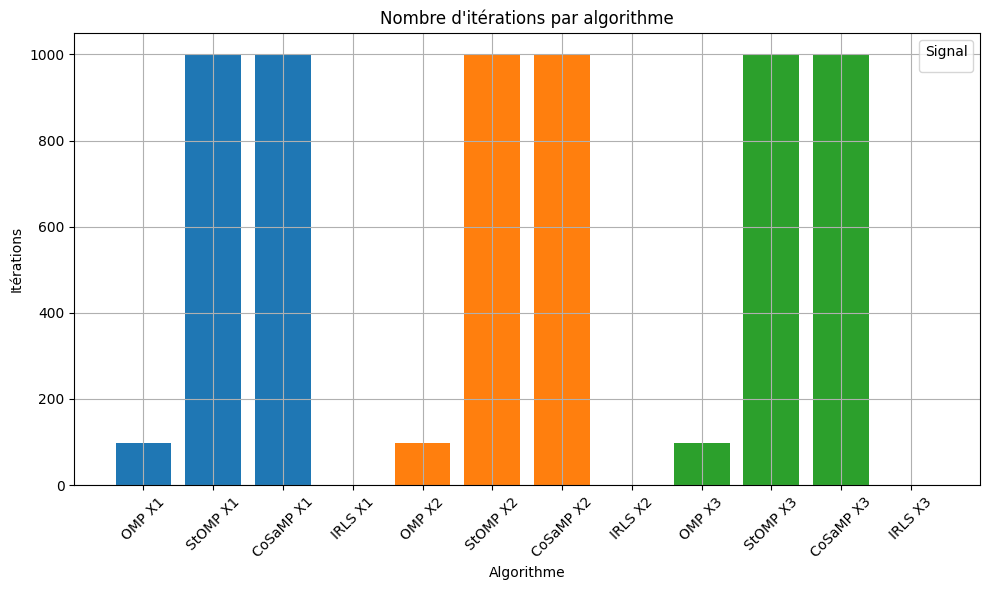

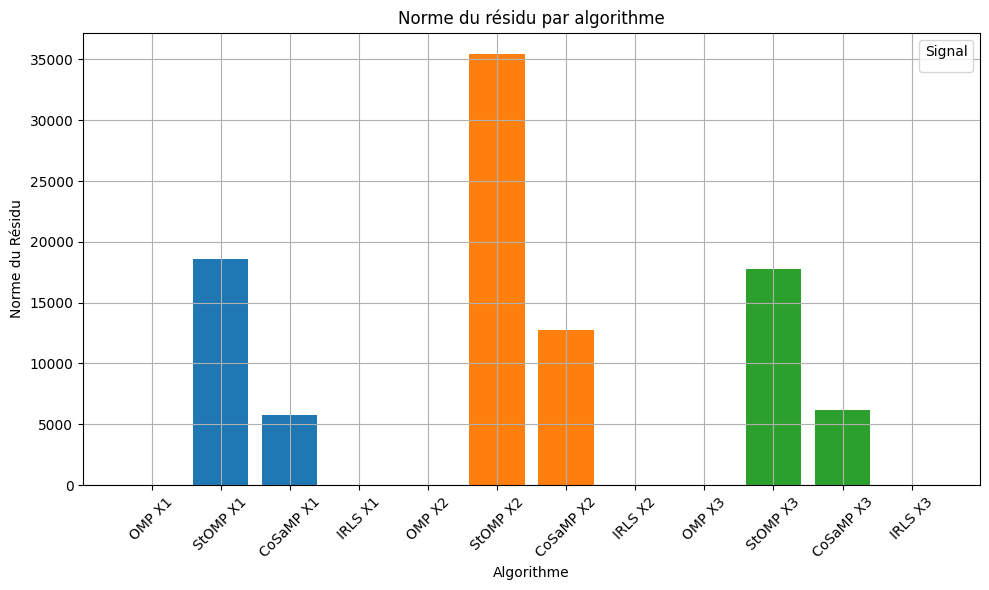

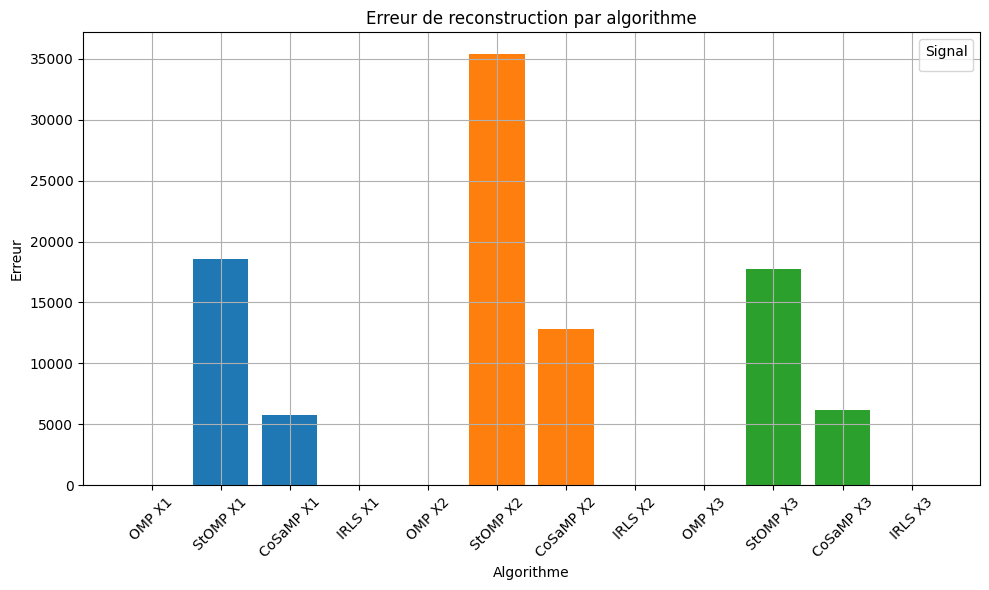

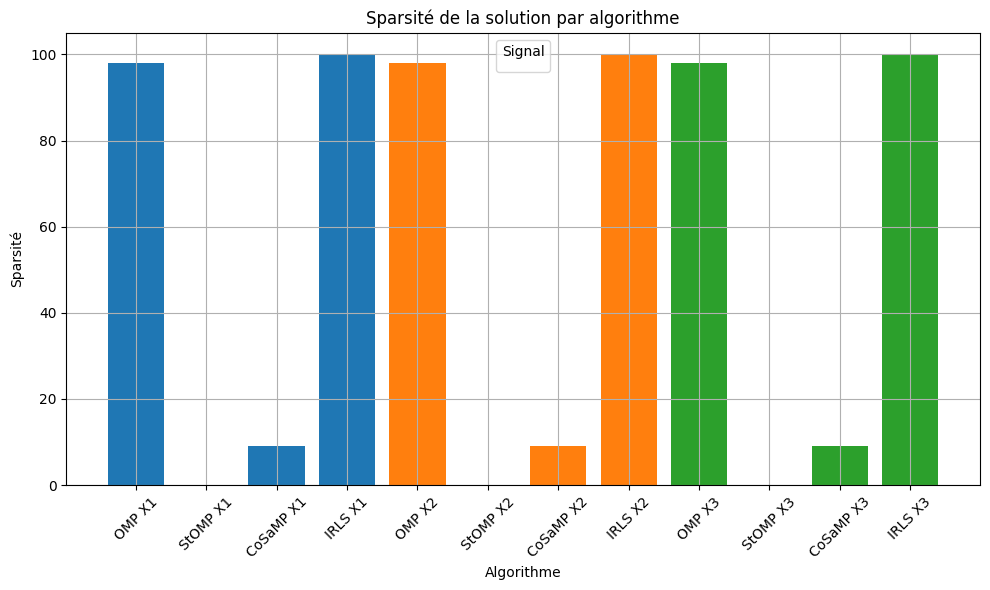

In [160]:
# Import des librairies nécessaires
import numpy as np
from numpy.linalg import pinv
from numpy.linalg import norm
import pandas as pd
from sklearn.preprocessing import normalize
from math import*
import time
import matplotlib.pyplot as plt

# Étape 1 : Charger le dictionnaire appris
D = pd.read_csv('./Dico-appris.csv', header=None, dtype=float).values


# Charger les signaux depuis le fichier Excel, en utilisant la première ligne comme en-tête
df_signals = pd.read_excel("/content/CompressiveSensingProject/DonneesProjet.xlsx", sheet_name="vecteurs pour valider")  # header=0 est la valeur par défaut


X1 = df_signals.iloc[:, 0].values
X2 = df_signals.iloc[:, 1].values
X3 = df_signals.iloc[:, 2].values


X1 = pd.to_numeric(X1, errors='coerce')
X2 = pd.to_numeric(X2, errors='coerce')
X3 = pd.to_numeric(X3, errors='coerce')


# Définition des algorithmes
# Fonction OMP corrigée
def OMP(x, D, eps, iterMax=1000):
    n, k = D.shape
    alpha = np.zeros(k)
    R = x.copy()
    index = []
    A = np.empty((n, 0))
    iterations = 0

    while np.linalg.norm(R) > eps and iterations < iterMax:
        ps = np.abs(D.T @ R)
        m = np.argmax(ps)
        index.append(m)
        A = D[:, index]
        alpha_solved = np.linalg.lstsq(A, x, rcond=None)[0]
        alpha = np.zeros(k)
        for i, ind in enumerate(index):
            alpha[ind] = alpha_solved[i]
        R = x - A @ alpha_solved
        iterations += 1

    return alpha, np.linalg.norm(R), iterations, index

# Fonction StOMP corrigée
def StOMP(x, D, eps, iterMax=1000, t=2):
    n, k = D.shape
    alpha = np.zeros(k)
    R = x.copy()
    index = []
    iterations = 0

    while np.linalg.norm(R) > eps and iterations < iterMax:
        ps = np.abs(D.T @ R)
        threshold = t * np.max(ps)
        indices_to_add = np.where(ps > threshold)[0]
        index = list(set(index) | set(indices_to_add))
        A = D[:, index]
        alpha_solved = np.linalg.lstsq(A, x, rcond=None)[0]
        alpha = np.zeros(k)
        for i, ind in enumerate(index):
            alpha[ind] = alpha_solved[i]
        R = x - A @ alpha_solved
        iterations += 1

    return alpha, np.linalg.norm(R), iterations, index

import numpy as np

def CoSaMP(x, D, eps, iterMax, s=9):
    n, k = np.shape(D)
    alpha = np.zeros(k)
    R = x.copy()
    iterations = 0

    while np.linalg.norm(R) > eps and iterations < iterMax:
        # Étape 1 : Corrélation
        ps = np.abs(D.T @ R)

        # Étape 2 : Sélection des 2s indices les plus significatifs
        m = np.argpartition(-ps, 2*s)[:2*s]

        # Étape 3 : Union des nouveaux indices avec les précédents
        # Dans votre version originale, 'index' était utilisé mais pas initialisé correctement pour le cycle.
        # 'V' doit contenir les indices actuels plus les nouveaux indices les plus significatifs.
        V = set(m)
        index = list(V)

        # Étape 4 : Résolution des moindres carrés sur l'ensemble d'indices sélectionnés
        A = D[:, index]
        alpha_solved = np.linalg.lstsq(A, x, rcond=None)[0]

        # Étape 5 : Garder les s plus grandes valeurs en magnitude et mettre à jour alpha
        idx_large_coefs = np.argsort(-np.abs(alpha_solved))[:s]
        alpha = np.zeros(k)
        for idx in idx_large_coefs:
            alpha[index[idx]] = alpha_solved[idx]

        # Étape 6 : Mise à jour du résidu
        R = x - D @ alpha
        iterations += 1

    return alpha, np.linalg.norm(R), iterations,None



# Fonction IRLS corrigée
def IRLS(x, D, eps, iterMax, p):
  n, k = np.shape(D)
  alpha0 = np.zeros(k)
  alpha = np.zeros(k)
  Q = np.zeros((k,k))
  it = 0

  # Initialisation de alpha
  alpha = D.T@np.linalg.inv(D@D.T)@x
  test = True
  # Boucle principale
  while test and it<iterMax:
    # Construction de la matrice Q
    for i in range(k):
      z = (np.abs(alpha[i]**2+eps))**(p/2-1)
      Q[i,i] = 1/z
    # Calcul de alpha
    alphaQ = Q@D.T@np.linalg.inv(D@Q@D.T)@x
    # Critère d'arrêt
    if np.linalg.norm(alpha-alpha0)<np.sqrt(eps)/100 and eps<10**(-8):
      test = False
    else:
      eps = eps/10
      alpha0=alpha
      it += 1

    return alpha, np.linalg.norm(x - D @ alpha),it,None

algos = {
    'OMP': lambda x, D: OMP(x, D, eps=1e-4, iterMax=1000),
    'StOMP': lambda x, D: StOMP(x, D, eps=1e-4, iterMax=1000, t=2),
    'CoSaMP': lambda x, D: CoSaMP(x, D, eps=1e-4, iterMax=1000, s=9),
    'IRLS': lambda x, D: IRLS(x, D, eps=1e-4, iterMax=1000, p=0.5)
}

# Initialisez des listes pour collecter les résultats
results_iterations = []
results_norm = []
results_error = []
results_sparsity = []

signals = [X1, X2, X3]
signal_names = ['X1', 'X2', 'X3']

# Exécutez les algorithmes et collectez les métriques
for signal_name, x in zip(signal_names, signals):
    for algo_name, algo_func in algos.items():
        alpha, norm_R, iterations, _ = algo_func(x, D)  # Exécutez l'algorithme
        error = np.linalg.norm(x - D @ alpha)  # Erreur de reconstruction
        sparsity = np.count_nonzero(alpha)  # Sparsité de la solution

        # Collecte des résultats
        results_iterations.append({
            'Signal': signal_name,
            'Algorithme': algo_name,
            'Itérations': iterations
        })
        results_norm.append({
            'Signal': signal_name,
            'Algorithme': algo_name,
            'Norme du Résidu': norm_R
        })
        results_error.append({
            'Signal': signal_name,
            'Algorithme': algo_name,
            'Erreur de Reconstruction': error
        })
        results_sparsity.append({
            'Signal': signal_name,
            'Algorithme': algo_name,
            'Sparsité': sparsity
        })

# Conversion des résultats en DataFrame
df_results_iterations = pd.DataFrame(results_iterations)
df_results_norm = pd.DataFrame(results_norm)
df_results_error = pd.DataFrame(results_error)
df_results_sparsity = pd.DataFrame(results_sparsity)

# Fonction pour tracer les métriques
def plot_metric(df, metric, title, ylabel):
    plt.figure(figsize=(10, 6))
    for signal_name in signal_names:
        df_signal = df[df['Signal'] == signal_name]
        plt.bar(df_signal['Algorithme'] + ' ' + signal_name, df_signal[metric])
    plt.title(title)
    plt.ylabel(ylabel)
    plt.xlabel('Algorithme')
    plt.xticks(rotation=45)
    plt.legend(title='Signal')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Visualisation pour chaque métrique
plot_metric(df_results_iterations, 'Itérations', 'Nombre d\'itérations par algorithme', 'Itérations')
plot_metric(df_results_norm, 'Norme du Résidu', 'Norme du résidu par algorithme', 'Norme du Résidu')
plot_metric(df_results_error, 'Erreur de Reconstruction', 'Erreur de reconstruction par algorithme', 'Erreur')
plot_metric(df_results_sparsity, 'Sparsité', 'Sparsité de la solution par algorithme', 'Sparsité')

##**Partie 4 : Matrices de mesure**

###1. Calcul de la cohérence mutuelle entre le dictionnaire obtenu par k-SVD et les matrices vus en cours.

Nous allons construire les matrices de mesure $\Phi_1, \Phi_2, \Phi_3$ et $\Phi_4$ puis calculer leur cohérence mutuelle avec le dictionnaire appris par k-SVD.
- $\Phi_1$ : matrice aléatoire obtenue par une loi uniforme $U(0, 1)$
- $\Phi_2$ : matrice aléatoire obtenue par une loi de Bernouilli avec pour valeurs -1 ou 1.
- $\Phi_3$ : matrice aléatoire obtenue par une loi de Bernouilli avec pour valeurs 0 ou 1.
- $\Phi_4$ : matrice aléatoire obtenue par une loi normale $𝓝(0, {\frac{1}{M}})$.

La cohérence mutuelle est une mesure statistique utilisée pour quantifier la corrélation entre deux variables aléatoires ou séries temporelles. Elle évalue la similarité des variations entre ces deux ensembles de données. Une cohérence mutuelle élevée indique une forte corrélation entre les deux ensembles de données, tandis qu'une cohérence mutuelle faible ou nulle suggère une faible corrélation.
Ici, notre objectif est de trouver la matrice de mesure pour laquelle sa cohérence mutuelle avec notre dictionnaire appris par k-SVD est la plus faible. Ainsi, nous assurons une dispersion maximum des données.

La cohérence mutuelle se calcule de la manière suivante : $\mu(\Phi,D) = \sqrt{N} \max_{i,j} {\frac {|<Φ_{i,.},D_{.,j}>|} {||\Phi_{i,.}||×||D_{.,j}||}}$




In [155]:
# Construction des matrices de mesure
def phi1(m, n):
  p = np.random.rand(m, n)
  return p

def phi2(m, n):
  proba = 0.25
  p = 2*np.random.binomial(1, proba, size=(m,n))-np.ones((m,n))
  return p

def phi3(m,n):
  proba = 0.25
  p = np.random.binomial(1, proba, size=(m,n))
  return p

def phi4(m,n):
  p = np.random.normal(0, 1/np.sqrt(m), size=(m,n))
  return p

In [156]:
# Fonction calculant la cohérence mutuelle
def coherence(phi, D):
  m, n = np.shape(phi)
  n, k = np.shape(D)
  coher = np.zeros((m,k))
  for i in range(m):
    for j in range(k):
      z = np.dot(phi[i,:].T, D[:,j])/(np.linalg.norm(phi[i,:])*np.linalg.norm(D[:,j]))
      # Calcul de la valeur absolue
      coher[i,j] = np.abs(z)
  a = np.max(coher)
  c = a*np.sqrt(n)
  return c

Calculons la cohérence mutuelle de ces matrices de mesure avec le dictionnaire appris par k-SVD, pour $M = 15, 20, 25, 30$ et $50$%.

Nos cohérences mutuelles doivent être comprises dans l'intervalle suivant :
$1 \leq μ(Φ,D)\leq \sqrt{N}$

In [157]:
# Import du dictionnaire appris par k-SVD
D = np.array(pd.read_csv('/content/CompressiveSensingProject/Dico-appris.csv'))

# Taille du dictionnaire
n = D.shape[0]

# Calcul des cohérences mutuelles
mesures = [0.15, 0.2, 0.25, 0.3, 0.5]

for i in mesures:
  m = int(i*n)
  # Calcul des matrices de mesure
  p1 = phi1(m, n)
  p2 = phi2(m, n)
  p3 = phi3(m, n)
  p4 = phi4(m, n)

  # Calcul des cohérences
  coher1 = coherence(p1, D)
  coher2 = coherence(p2, D)
  coher3 = coherence(p3, D)
  coher4 = coherence(p4, D)

  # Afficher les cohérences mutuelles
  print(f" Pour {i}% les cohérences mutuelles sont en utilisant :\nPhi1 = {coher1}, Phi2 = {coher2}, Phi3 = {coher3} et Phi4 = {coher4}\n")


 Pour 0.15% les cohérences mutuelles sont en utilisant :
Phi1 = 8.338897912962512, Phi2 = 7.1323925089330755, Phi3 = 5.893465959734528 et Phi4 = 2.462068998877594

 Pour 0.2% les cohérences mutuelles sont en utilisant :
Phi1 = 8.367760995981305, Phi2 = 5.896059977833209, Phi3 = 6.194983492636933 et Phi4 = 3.073929284595599

 Pour 0.25% les cohérences mutuelles sont en utilisant :
Phi1 = 8.42178352884217, Phi2 = 6.745035224310099, Phi3 = 6.426739846192202 et Phi4 = 2.565580249027297

 Pour 0.3% les cohérences mutuelles sont en utilisant :
Phi1 = 8.36784773555181, Phi2 = 6.762683514312745, Phi3 = 6.248488662383334 et Phi4 = 3.5561998505135266

 Pour 0.5% les cohérences mutuelles sont en utilisant :
Phi1 = 8.32802379660039, Phi2 = 6.429218637035231, Phi3 = 6.110890039384475 et Phi4 = 3.1318958798815606



On retient la matrice de mesure ayant la plus petite cohérence pour éviter au maximum la redondance. Ici, c'est $\Phi_4$, la matrice générée par la loi Normale, qui a la plus petite cohérence avec une mesure de 25% et qu'il faut conserver.

###2. Appliquer la procédure de Compressive Sensing aux 3 signaux test pour les reconstruire et comparer les signaux reconstruits avec les signaux d’origine.

Tout d'abord, explicitons la procédure de Compressive Sensing :

1. Apprentissage du dictionnaire par k-SVD.
2. Détermination de l'algorithme de codage parcimonieux à utiliser.
3. Détermination de la matrice de mesure $\Phi$.
4. Calcul de $y = Φx$.
5. Reconstruction du signal avec $A=\Phi D$ pour obtenir $x=Dα$.

Dans les parties précédentes, l'algorithme de codage parcimonieux sélectionné est CoSaMP et la matrice de mesure sélectionnée est $Φ_4$ avec une mesure de $25$%.

In [158]:
def omp_compressed(y, Phi, D, eps, iterMax):
    # y est le signal compressé, Phi est la matrice de mesure, et D est le dictionnaire.
    M, N = Phi.shape  # Récupération des dimensions de la matrice de mesure
    _, k = D.shape  # Récupération des dimensions du dictionnaire
    alpha = np.zeros(k)  # Initialisation des coefficients
    R = y  # Initialisation du résidu avec le signal compressé
    index = []  # Liste pour stocker les indices des atomes sélectionnés
    A = np.empty((M, 0))  # Matrice initialement vide qui va contenir les atomes sélectionnés projetés

    it = 0  # Compteur d'itérations
    while LA.norm(R) > eps and it < iterMax:  # Critère d'arrêt
        ps = np.zeros(k)
        for j in range(k):
            D_j = np.dot(Phi, D[:, j])  # Application de la matrice de mesure au j-ème atome
            ps[j] = np.abs(np.dot(D_j.T, R)) / LA.norm(D_j)
        m = np.argmax(ps)
        index.append(m)
        A = np.column_stack([A, np.dot(Phi, D[:, m])])  # Ajouter l'atome projeté
        alpha_temp = LA.lstsq(A, y, rcond=None)[0]  # Solution des moindres carrés
        alpha[index] = alpha_temp
        R = y - np.dot(A, alpha_temp)  # Mise à jour du résidu
        it += 1
    return alpha, R, it, index

In [159]:
# Import du dictionnaire appris par k-SVD
D = np.array(pd.read_csv('/content/CompressiveSensingProject/Dico-appris.csv'))

# Import des signaux test
X = np.array(pd.read_excel("/content/CompressiveSensingProject/DonneesProjet.xlsx", sheet_name="vecteurs pour valider"))
X = X[1:,:]

# Construction de la matrice de mesure aléatoire sélectionnée précédemment
n = X.shape[0]
i = 0.25 # Mesure sélectionnée précédemment
m = int(i*n)
phi = phi4(m,n)

# Echantillonage compressif
y = np.dot(phi, X)

# Reconstruction des signaux
s = 10

# Initialiser la matrice reconstruite
X_reconstruit = np.zeros_like(X)

# Reconstruction de chaque signal compressé
for i in range(y.shape[1]):
  alpha, R, it, index = omp_compressed(y[:, i], phi, D, eps, iterMax)
  # Reconstruction du signal à partir des coefficients
  X_reconstruit[:, i] = np.dot(D, alpha)

# Convertir le dictionnaire numpy en DataFrame pandas
df = pd.DataFrame(X)

# Enregistrer le tableau NumPy dans un fichier CSV
df.to_csv("X_reconstruit.csv", index=False, header=True)

X_reconstruit = pd.read_csv("./X_reconstruit.csv")

# Calcul du MSE pour chaque colonne
MSE = ((X - X_reconstruit) ** 2).mean(axis=0)

print("La Mean Square Error pour chaque atome")
for i, mse in enumerate(MSE):
    print(f"Signal {i + 1}: {mse:.4f}")

La Mean Square Error pour chaque atome
Signal 1: 0.0000
Signal 2: 0.0000
Signal 3: 0.0000


Étant donné que nous n'avons pas réussi à reconstruire les signaux avec CosaMP, nous avons utilisé l'algorithme omp_compressed. Cepedant, nous avons comme MSE = 0 pour chacun des signaux. Cela n'est pas un résultat logique.